Set parameter TimeLimit to value 600
Set parameter Heuristics to value 0.1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 11131 rows, 13440 columns and 47870 nonzeros
Model fingerprint: 0x32d22c1d
Model has 3072 quadratic constraints
Variable types: 13152 continuous, 288 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+06]
  QMatrix range    [4e+00, 4e+00]
  QLMatrix range   [6e+02, 6e+02]
  Objective range  [2e-01, 6e-01]
  Bounds range     [1e+01, 4e+04]
  RHS range        [6e-02, 2e+08]
Presolve removed 1991 rows and 1222 columns
Presolve time: 0.93s
Presolved: 9140 rows, 12218 columns, 41923 nonzeros
Presolved model has 3072 quadratic constraint(s)
Variable types: 12026 continuous, 192 integer (0 binary)

Root relaxation: objective 3.121978e+04, 4195 iterations, 0.07 

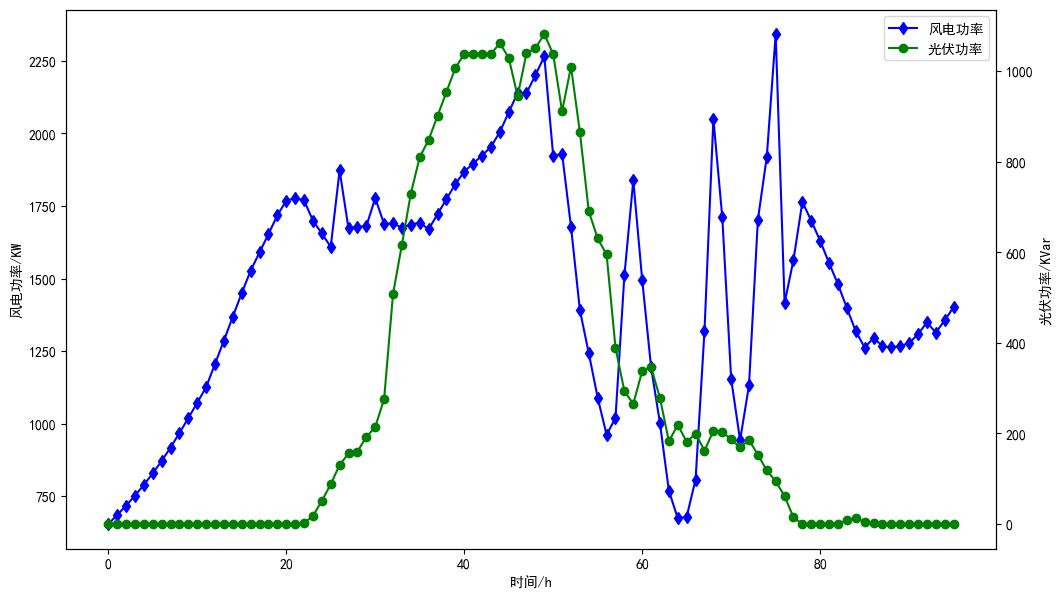

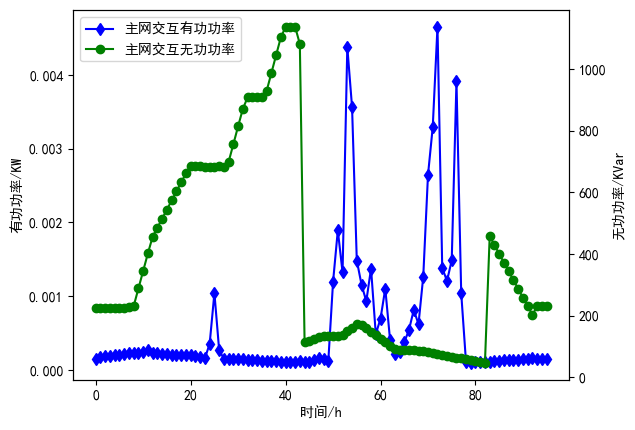

In [32]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import matplotlib.pyplot as plt
from data import *
from IDC_parameters import *
from uncertainty_modelling import WT_96points_quantiles,WT_simulation,PV_simulation,PV_96points_quantiles,load_96points_quantiles
#任务2 以最优潮流问题为基础的96点优化调度
#负荷比例：24个小时中，每个时间点每个节点的有功/无功负荷相对基准值（即开头表中值）的比例
#负荷根据实际需要任意修改即可，这里只做实验用
def interpolate_data(data):
    # Ensure input data length is 24
    if len(data) != 24:
        raise ValueError("Input array must have exactly 24 elements.")
    
    # Original x coordinates, from 0 to 23
    x_original = np.arange(24)
    
    # New x coordinates, from 0 to 95, total 96 points
    x_new = np.linspace(0, 24, 96)
    
    # Use linear interpolation function
    f = interp1d(x_original, data, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Interpolate and get new data
    interpolated_data = f(x_new[:-3])  # Handle the first 93 points
    
    # Special handling for the last three points, using the first and last point of the original array for interpolation
    last_point = data[-1]
    first_point = data[0]
    extended_x = np.array([24, 25, 26])
    extended_y = np.array([last_point, first_point, first_point])
    
    # Extended interpolation function
    f_extended = interp1d(extended_x, extended_y, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Get the data for the last three points
    last_three_points = f_extended(x_new[-3:])
    
    # Combine the two parts of data
    final_data = np.concatenate((interpolated_data, last_three_points))
    
    return final_data

predicted_BWs=3e2*np.array([1.3,2,3.7,4,5.4,5.7,6,6.4,6.8,6,5.8,5.6,5.4,5.7,6,6.4,6.8,6.4,6,5.6,4,3.7,2,1.6])
predicted_IWs=3e2*np.array([0.75,1.2,1.6,2.2,2.75,3.2,3.4,3.5,3.45,3.2,3.0,2.9,
                                        2.9,3.0,3.2,3.4,3.5,3.4,3.2,2.8,2.2,1.6,1.1,0.7])
pq_ratio=np.array([0.1,0.1,0.1,0.2,0.25,0.3,
                   0.3,0.3,0.4,0.4,0.5,0.5,
                   0.6,0.6,0.8,0.6,0.4,0.4,
                   0.36,0.3,0.25,0.2,0.15,0.1])
electricity_price=np.array([29,26,23,23,24,25,31,30,32,33,34,35,37,41,44,52,62,50,40,36,38,34,32,30])
IW_simulation=interpolate_data(predicted_IWs)
BW_simulation=interpolate_data(predicted_BWs)
pq_ratio=interpolate_data(pq_ratio)
electricity_price=interpolate_data(electricity_price)/100
model2=gp.Model('96 point OPF')
#声明各个决策变量，每一个96维的变量表示该节点/电机/线路96个小时中每小时的功率
gen_P=model2.addVars(96,lb=0,ub=6000,vtype=GRB.CONTINUOUS,name=f'generator_p')
gen_Q=model2.addVars(96,lb=0,ub=6000,vtype=GRB.CONTINUOUS,name=f'generator_q')
P_WT_t=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_WT_t')
P_PV_t=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_PV_t')

bus_square_voltages,branch_P,branch_Q,branch_square_currents=[],[],[],[]

A_max=3000

for i in range(32):
    tmp_bus_square_voltage=model2.addVars(96,lb=Vmin*Vmin,ub=Vmax*Vmax,vtype=GRB.CONTINUOUS,name=f'bus_square_voltage_{i+1}')
    tmp_branch_p=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_P_{i+1}')
    tmp_branch_q=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_Q_{i+1}')
    tmp_branch_square_current=model2.addVars(96,lb=0,ub=4e4,vtype=GRB.CONTINUOUS,name=f'branch_square_{i+1}')
    bus_square_voltages.append(tmp_bus_square_voltage)
    branch_P.append(tmp_branch_p)
    branch_Q.append(tmp_branch_q)
    branch_square_currents.append(tmp_branch_square_current) 
    
#发电机爬坡功率约束,设发电机爬坡能力为400kW/h
for j in range(1,96):
    model2.addConstr(gen_P[j]-gen_P[j-1]<=1000)
    model2.addConstr(gen_P[j]-gen_P[j-1]>=-1000)
    model2.addConstr(gen_Q[j]-gen_Q[j-1]<=1000)
    model2.addConstr(gen_Q[j]-gen_Q[j-1]>=-1000)
    model2.addConstr(P_WT_t[j]<=max(0,(WT_simulation[j]+WT_96points_quantiles[j])))
    model2.addConstr(P_PV_t[j]<=max(0,(PV_simulation[j]+PV_96points_quantiles[j])))

T=96
TD=16

A_BW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_BW_t')
A_IW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_IW_t')
A_R_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_R_t')
L_BW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_BW_t')
L_IW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_IW_t')
#P_res_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_res_t')
P_data_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_data_t')
P_cooling_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='p_cooling_t')
T_cooling=model2.addVars(T,lb=10,ub=40,vtype=GRB.CONTINUOUS,name='T_cooling')

#数据中心相关约束
#数据处理相关约束
for i in range(T):
    model2.addConstr(P_data_t[i]==(P_idle+0.75*P_peak)*(A_BW_t[i]+A_IW_t[i])+P_idle*A_R_t[i]+(L_BW_t[i]+L_IW_t[i])*(P_peak-P_idle)/L_rate)
    model2.addConstr(A_IW_t[i]>=L_IW_t[i]/(L_rate-1/C_DT))
    model2.addConstr(L_IW_t[i]==IW_simulation[i]+load_96points_quantiles[i])
    model2.addConstr(L_rate*A_BW_t[i]>=L_BW_t[i])
    #对于可延迟负荷，当前处理的功率（累计值）小于当前的负荷值
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i))<=gp.quicksum(BW_simulation[j] for j in range(0,i)))
    #在截止时间之前处理完毕
for i in range(T-TD):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i+TD))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T-TD,T):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,T))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T):
    model2.addConstr(A_R_t[i]>=redundant_ratio*A_max)
    model2.addConstr(A_IW_t[i]+A_BW_t[i]+A_R_t[i]<=A_max)
#数据中心制冷相关约束
#初始状态T_cooling=T_env=22℃
model2.addConstr(P_cooling_t[0]<=1000)
model2.addConstr(T_cooling[0]==cooling_coef*22+(1-cooling_coef)*T_env[0]+cooling_g*(1-cooling_coef)*P_data_t[0]
                 -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[0])
model2.addConstr(T_cooling[0]>=20)
model2.addConstr(T_cooling[0]<=24)
for i in range(1,96):
    model2.addConstr(P_cooling_t[i]<=1000)
    model2.addConstr(T_cooling[i]==cooling_coef*T_cooling[i-1]+(1-cooling_coef)*T_env[i]+cooling_g*(1-cooling_coef)*P_data_t[i]
                     -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[i])
    model2.addConstr(T_cooling[i]>=20)
    model2.addConstr(T_cooling[i]<=24)      
model2.addConstr(T_cooling[95]==22)

for i in range(96):
    model2.addConstr(branch_P[0][i]<=4000)
    model2.addConstr(branch_Q[0][i]<=4000)
#主线
#节点2
#后一个节点电压=前一个节点电压和功率、电流的关系
#后面统一循环变量i表示时间点，循环变量j表示节点
#发电机的懒得改了
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[0][i]==1e6*Vm*Vm-2*1e3*(branch_r[0]*branch_P[0][i]+branch_x[0]*branch_Q[0][i])
                    +(branch_r[0]*branch_r[0]+branch_x[0]*branch_x[0])*branch_square_currents[0][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[0][i]+P_WT_t[i]-branch_square_currents[0][i]*branch_r[0]/1e3==bus_Pd[0]*pq_ratio[i]+branch_P[1][i]+branch_P[17][i])
    model2.addConstr(branch_Q[0][i]-branch_square_currents[0][i]*branch_x[0]/1e3==bus_Qd[0]*pq_ratio[i]+branch_Q[1][i]+branch_Q[17][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[0][i]**2+4*branch_Q[0][i]**2+(branch_square_currents[0][i]-Vm*Vm)**2<=
                    (branch_square_currents[0][i]+Vm*Vm)**2)
#节点3
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[1][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[1]*branch_P[1][i]+branch_x[1]*branch_Q[1][i])
                    +(branch_r[1]*branch_r[1]+branch_x[1]*branch_x[1])*branch_square_currents[1][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[1][i]+gen_P[i]-branch_square_currents[1][i]*branch_r[1]/1e3==bus_Pd[1]*pq_ratio[i]+branch_P[2][i]+branch_P[21][i])
    model2.addConstr(branch_Q[1][i]+gen_Q[i]-branch_square_currents[1][i]*branch_x[1]/1e3==bus_Qd[1]*pq_ratio[i]+branch_Q[2][i]+branch_Q[21][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[1][i]**2+4*branch_Q[1][i]**2+(branch_square_currents[1][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[1][i]+bus_square_voltages[0][i])**2)
#节点4
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[2][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[2]*branch_P[2][i]+branch_x[2]*branch_Q[2][i])
                    +(branch_r[2]*branch_r[2]+branch_x[2]*branch_x[2])*branch_square_currents[2][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[2][i]-branch_square_currents[2][i]*branch_r[2]/1e3==bus_Pd[2]*pq_ratio[i]+branch_P[3][i])
    model2.addConstr(branch_Q[2][i]-branch_square_currents[2][i]*branch_x[2]/1e3==bus_Qd[2]*pq_ratio[i]+branch_Q[3][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[2][i]**2+4*branch_Q[2][i]**2+(branch_square_currents[2][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[2][i]+bus_square_voltages[1][i])**2)
#节点5
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[3][i]==1e6*bus_square_voltages[2][i]-2*1e3*(branch_r[3]*branch_P[3][i]+branch_x[3]*branch_Q[3][i])
                    +(branch_r[3]*branch_r[3]+branch_x[3]*branch_x[3])*branch_square_currents[3][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[3][i]-branch_square_currents[3][i]*branch_r[3]/1e3==bus_Pd[3]*pq_ratio[i]+branch_P[4][i]+P_data_t[i]+P_cooling_t[i])
    model2.addConstr(branch_Q[3][i]-branch_square_currents[3][i]*branch_x[3]/1e3==bus_Qd[3]*pq_ratio[i]+branch_Q[4][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[3][i]**2+4*branch_Q[3][i]**2+(branch_square_currents[3][i]-bus_square_voltages[2][i])**2<=
                    (branch_square_currents[3][i]+bus_square_voltages[2][i])**2)
#节点6
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[4][i]==1e6*bus_square_voltages[3][i]-2*1e3*(branch_r[4]*branch_P[4][i]+branch_x[4]*branch_Q[4][i])
                    +(branch_r[4]*branch_r[4]+branch_x[4]*branch_x[4])*branch_square_currents[4][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[4][i]+P_PV_t[i]-branch_square_currents[4][i]*branch_r[4]/1e3==bus_Pd[4]*pq_ratio[i]+branch_P[5][i]+branch_P[24][i])
    model2.addConstr(branch_Q[4][i]-branch_square_currents[4][i]*branch_x[4]/1e3==bus_Qd[4]*pq_ratio[i]+branch_Q[5][i]+branch_Q[24][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[4][i]**2+4*branch_Q[4][i]**2+(branch_square_currents[4][i]-bus_square_voltages[3][i])**2<=
                    (branch_square_currents[4][i]+bus_square_voltages[3][i])**2)
#节点7到17
#再次强调：循环变量i表示时间点，循环变量j表示节点和线路的编号
for j in range(7,18):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][i]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点18
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[16][i]==1e6*bus_square_voltages[15][i]-2*1e3*(branch_r[16]*branch_P[16][i]+branch_x[16]*branch_Q[16][i])
                    +(branch_r[16]*branch_r[16]+branch_x[16]*branch_x[16])*branch_square_currents[16][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[16][i]-branch_square_currents[16][i]*branch_r[16]/1e3==bus_Pd[16]*pq_ratio[i])
    model2.addConstr(branch_Q[16][i]-branch_square_currents[16][i]*branch_x[16]/1e3==bus_Qd[16]*pq_ratio[i])
    #线上电流关系
    model2.addQConstr(4*branch_P[16][i]**2+4*branch_Q[16][i]**2+(branch_square_currents[16][i]-bus_square_voltages[15][i])**2<=
                    (branch_square_currents[16][i]+bus_square_voltages[15][i])**2)
    
#支路1：节点19到节点22
#节点19
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[17][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[17]*branch_P[17][i]+branch_x[17]*branch_Q[17][i])
                    +(branch_r[17]*branch_r[17]+branch_x[17]*branch_x[17])*branch_square_currents[17][i])
    model2.addConstr(branch_P[17][i]-branch_square_currents[17][i]*branch_r[17]/1e3==bus_Pd[17]*pq_ratio[i]+branch_P[18][i])
    model2.addConstr(branch_Q[17][i]-branch_square_currents[17][i]*branch_x[17]/1e3==bus_Qd[17]*pq_ratio[i]+branch_Q[18][i])
    model2.addQConstr(4*branch_P[17][i]**2+4*branch_Q[17][i]**2+(branch_square_currents[17][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[17][i]+bus_square_voltages[0][i])**2)
#节点20
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[18][i]==1e6*bus_square_voltages[17][i]-2*1e3*(branch_r[18]*branch_P[18][i]+branch_x[18]*branch_Q[18][i])
                    +(branch_r[18]*branch_r[18]+branch_x[18]*branch_x[18])*branch_square_currents[18][i])
    model2.addConstr(branch_P[18][i]-branch_square_currents[18][i]*branch_r[18]/1e3==bus_Pd[18]*pq_ratio[i]+branch_P[19][i])
    model2.addConstr(branch_Q[18][i]-branch_square_currents[18][i]*branch_x[18]/1e3==bus_Qd[18]*pq_ratio[i]+branch_Q[19][i])
    model2.addQConstr(4*branch_P[18][i]**2+4*branch_Q[18][i]**2+(branch_square_currents[18][i]-bus_square_voltages[17][i])**2<=
                    (branch_square_currents[18][i]+bus_square_voltages[17][i])**2)
#节点21
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[19][i]==1e6*bus_square_voltages[18][i]-2*1e3*(branch_r[19]*branch_P[19][i]+branch_x[19]*branch_Q[19][i])
                    +(branch_r[19]*branch_r[19]+branch_x[19]*branch_x[19])*branch_square_currents[19][i])
    model2.addConstr(branch_P[19][i]-branch_square_currents[19][i]*branch_r[19]/1e3==bus_Pd[19]*pq_ratio[i]+branch_P[20][i])
    model2.addConstr(branch_Q[19][i]-branch_square_currents[19][i]*branch_x[19]/1e3==bus_Qd[19]*pq_ratio[i]+branch_Q[20][i])
    model2.addQConstr(4*branch_P[19][i]**2+4*branch_Q[19][i]**2+(branch_square_currents[19][i]-bus_square_voltages[18][i])**2<=
                    (branch_square_currents[19][i]+bus_square_voltages[18][i])**2)
#节点22
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[20][i]==1e6*bus_square_voltages[19][i]-2*1e3*(branch_r[20]*branch_P[20][i]+branch_x[20]*branch_Q[20][i])
                    +(branch_r[20]*branch_r[20]+branch_x[20]*branch_x[20])*branch_square_currents[20][i])
    model2.addConstr(branch_P[20][i]-branch_square_currents[20][i]*branch_r[20]/1e3==bus_Pd[20]*pq_ratio[i])
    model2.addConstr(branch_Q[20][i]-branch_square_currents[20][i]*branch_x[20]/1e3==bus_Qd[20]*pq_ratio[i])
    model2.addQConstr(4*branch_P[20][i]**2+4*branch_Q[20][i]**2+(branch_square_currents[20][i]-bus_square_voltages[19][i])**2<=
                    (branch_square_currents[20][i]+bus_square_voltages[19][i])**2)

#支路2：节点23到节点25
#节点23
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[21][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[21]*branch_P[21][i]+branch_x[21]*branch_Q[21][i])
                    +(branch_r[21]*branch_r[21]+branch_x[21]*branch_x[21])*branch_square_currents[21][i])
    model2.addConstr(branch_P[21][i]-branch_square_currents[21][i]*branch_r[21]/1e3==bus_Pd[21]*pq_ratio[i]+branch_P[22][i])
    model2.addConstr(branch_Q[21][i]-branch_square_currents[21][i]*branch_x[21]/1e3==bus_Qd[21]*pq_ratio[i]+branch_Q[22][i])
    model2.addQConstr(4*branch_P[21][i]**2+4*branch_Q[21][i]**2+(branch_square_currents[21][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[21][i]+bus_square_voltages[1][i])**2)
#节点24
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[22][i]==1e6*bus_square_voltages[21][i]-2*1e3*(branch_r[22]*branch_P[22][i]+branch_x[22]*branch_Q[22][i])
                    +(branch_r[22]*branch_r[22]+branch_x[22]*branch_x[22])*branch_square_currents[22][i])
    model2.addConstr(branch_P[22][i]-branch_square_currents[22][i]*branch_r[22]/1e3==bus_Pd[22]*pq_ratio[i]+branch_P[23][i])
    model2.addConstr(branch_Q[22][i]-branch_square_currents[22][i]*branch_x[22]/1e3==bus_Qd[22]*pq_ratio[i]+branch_Q[23][i])
    model2.addQConstr(4*branch_P[22][i]**2+4*branch_Q[22][i]**2+(branch_square_currents[22][i]-bus_square_voltages[21][i])**2<=
                    (branch_square_currents[22][i]+bus_square_voltages[21][i])**2)
#节点25
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[23][i]==1e6*bus_square_voltages[22][i]-2*1e3*(branch_r[23]*branch_P[23][i]+branch_x[23]*branch_Q[23][i])
                    +(branch_r[23]*branch_r[23]+branch_x[23]*branch_x[23])*branch_square_currents[23][i])
    model2.addConstr(branch_P[23][i]-branch_square_currents[23][i]*branch_r[23]/1e3==bus_Pd[23]*pq_ratio[i])
    model2.addConstr(branch_Q[23][i]-branch_square_currents[23][i]*branch_x[23]/1e3==bus_Qd[23]*pq_ratio[i])
    model2.addQConstr(4*branch_P[23][i]**2+4*branch_Q[23][i]**2+(branch_square_currents[23][i]-bus_square_voltages[22][i])**2<=
                    (branch_square_currents[23][i]+bus_square_voltages[22][i])**2)

#支路3：节点26到节点33
#节点26
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[24][i]==1e6*bus_square_voltages[4][i]-2*1e3*(branch_r[24]*branch_P[24][i]+branch_x[24]*branch_Q[24][i])
                    +(branch_r[24]*branch_r[24]+branch_x[24]*branch_x[24])*branch_square_currents[24][i])
    model2.addConstr(branch_P[24][i]-branch_square_currents[24][i]*branch_r[24]/1e3==bus_Pd[24]*pq_ratio[i]+branch_P[25][i])
    model2.addConstr(branch_Q[24][i]-branch_square_currents[24][i]*branch_x[24]/1e3==bus_Qd[24]*pq_ratio[i]+branch_Q[25][i])
    model2.addQConstr(4*branch_P[24][i]**2+4*branch_Q[24][i]**2+(branch_square_currents[24][i]-bus_square_voltages[4][i])**2<=
                    (branch_square_currents[24][i]+bus_square_voltages[4][i])**2)
#节点27到节点32
for j in range(27,33):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][2]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点33
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[31][i]==1e6*bus_square_voltages[30][i]-2*1e3*(branch_r[31]*branch_P[31][i]+branch_x[31]*branch_Q[31][i])
                    +(branch_r[31]*branch_r[31]+branch_x[31]*branch_x[31])*branch_square_currents[31][i])
    model2.addConstr(branch_P[31][i]-branch_square_currents[31][i]*branch_r[31]/1e3==bus_Pd[31]*pq_ratio[i])
    model2.addConstr(branch_Q[31][i]-branch_square_currents[31][i]*branch_x[31]/1e3==bus_Qd[31]*pq_ratio[i])
    model2.addQConstr(4*branch_P[31][i]**2+4*branch_Q[31][i]**2+(branch_square_currents[31][i]-bus_square_voltages[30][i])**2<=
                    (branch_square_currents[31][i]+bus_square_voltages[30][i])**2)
    

#先优化网损，别的目标函数（如经济性相关）可以自己随便调整
#model2.setObjective(1)
model2.setParam('TimeLimit',600)
model2.Params.Heuristics = 0.1  # 增加启发式算法的使用
#model2.Params.MIPFocus = 1  # 重点寻找最优解
#model.Params.Presolve = 0 
model2.setObjective(0.35*gp.quicksum(gen_P[i]  for i in range(T))+0.35*(gp.quicksum(gen_Q[i]  for i in range(T)))
                    +gp.quicksum(electricity_price[i]*branch_P[0][i] for i in range(T))+gp.quicksum(electricity_price[i]*branch_Q[0][i] for i in range(T)))
                    #+0.4*gp.quicksum(P_cooling_t[i] for i in range(T))
                    #-C_BW*gp.quicksum(L_BW_t[i] for i in range(T))-C_IW*(gp.quicksum(L_IW_t[i] for i in range(T))),GRB.MINIMIZE)
#model2.setObjective(gp.quicksum(gp.quicksum(branch_square_currents[j][i]*branch_r[j] for j in range(32)) for i in range(96)))

model2.optimize()
if model2.Status == GRB.INFEASIBLE:
    # 查找最小不可行子集
    model2.computeIIS()
    
    # 打印不可行子集中的约束
    for constr in model2.getConstrs():
        if constr.IISConstr:
            print(f"Constraint {constr.ConstrName} is in the IIS.")

gen_active_power,wind_power,photovaltaic_power,gen_reactive_power=[],[],[],[]
for i in range(96):
    gen_active_power.append(gen_P[i].X)
    gen_reactive_power.append(gen_Q[i].X)
    wind_power.append(P_WT_t[i].X)
    photovaltaic_power.append(P_PV_t[i].X)
utility_grid_active_power_exchange,utility_grid_reactive_power_exchange=[],[]
for i in range(96):
    utility_grid_active_power_exchange.append(branch_P[0][i].X)
    utility_grid_reactive_power_exchange.append(branch_Q[0][i].X)

plt.rcParams['font.sans-serif'] = ['SimHei'] 
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

#绘制三个发电机的出力曲线

fig1, ax1 = plt.subplots(figsize=(12,7))
'''
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(gen_active_power,marker='d',color='r',label='发电机有功功率')
ax2.plot(gen_reactive_power,marker='o',color='r',label='发电机无功功率')
plt.savefig('bingwang_fadianji.pdf',dpi=800)
plt.show()
'''
photovaltaic_power[0]=0
ax1.set_xlabel('时间/h')
ax1.set_ylabel('风电功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('光伏功率/KVar') 
ax1.plot(wind_power,marker='d',color='b',label='风电功率')
ax2.plot(photovaltaic_power,marker='o',color='g',label='光伏功率')


lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
plt.savefig('WTandPV.pdf',dpi=800)
plt.show()

#绘制主网交互功率曲线
fig1, ax1 = plt.subplots()
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(utility_grid_active_power_exchange,marker='d',color='b',label='主网交互有功功率')
ax2.plot(utility_grid_reactive_power_exchange,marker='o',color='g',label='主网交互无功功率')

lines1,labels1=ax1.get_legend_handles_labels()
lines2,labels2=ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='best')
plt.savefig('energy_exchange.pdf',dpi=800)
plt.show()





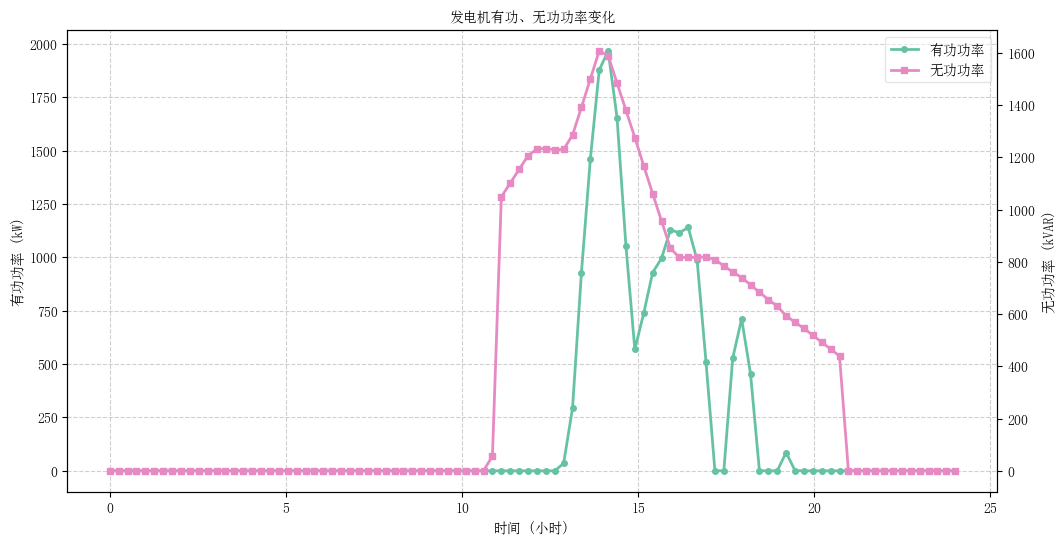

In [64]:
time_points = np.linspace(0, 24, 96)  # 96个时间点，每15分钟一个点
active_power = np.array(gen_active_power) # 有功功率示例数据
reactive_power = np.array(gen_reactive_power)  # 无功功率示例数据

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用于设置无衬线字体，一般用来显示中文
plt.rcParams['font.serif'] = ['Times New Roman']  # 用于设置有衬线字体，一般用来显示英文和数字
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制有功功率
color_active = '#66c2a5'  # 有功功率颜色
ax1.plot(time_points, active_power, color=color_active, linestyle='-', marker='o', markersize=4, linewidth=2, label='有功功率')
ax1.set_xlabel('时间 (小时)', color='black', fontproperties='SimSun')
ax1.set_ylabel('有功功率 (kW)', color='black', fontproperties='SimSun')
ax1.tick_params(axis='y', colors='black')
ax1.grid(True, linestyle='--', alpha=0.6)

# 创建第二个y轴来绘制无功功率
ax2 = ax1.twinx()
color_reactive = '#e78ac3'  # 无功功率颜色
ax2.plot(time_points, reactive_power, color=color_reactive, linestyle='-', marker='s', markersize=4, linewidth=2, label='无功功率')
ax2.set_ylabel('无功功率 (kVAR)', color='black', fontproperties='SimSun')
ax2.tick_params(axis='y', colors='black')

# 设置图表标题
plt.title('发电机有功、无功功率变化', color='black', fontproperties='SimSun')

# 设置图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', framealpha=0.5, prop={'family': 'SimSun'})

plt.savefig('发电机并网.png',dpi=300)

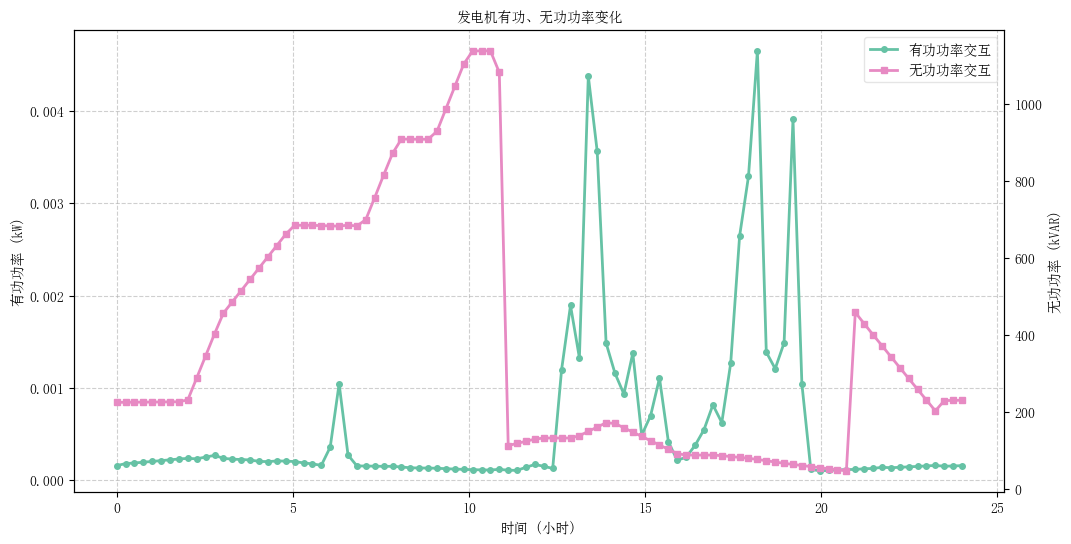

In [66]:
time_points = np.linspace(0, 24, 96)  # 96个时间点，每15分钟一个点
active_power = np.array(gen_active_power) # 有功功率示例数据
reactive_power = np.array(gen_reactive_power)  # 无功功率示例数据

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用于设置无衬线字体，一般用来显示中文
plt.rcParams['font.serif'] = ['Times New Roman']  # 用于设置有衬线字体，一般用来显示英文和数字
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制有功功率
color_active = '#66c2a5'  # 有功功率颜色
ax1.plot(time_points, utility_grid_active_power_exchange, color=color_active, linestyle='-', marker='o', markersize=4, linewidth=2, label='有功功率交互')
ax1.set_xlabel('时间 (小时)', color='black', fontproperties='SimSun')
ax1.set_ylabel('有功功率 (kW)', color='black', fontproperties='SimSun')
ax1.tick_params(axis='y', colors='black')
ax1.grid(True, linestyle='--', alpha=0.6)

# 创建第二个y轴来绘制无功功率
ax2 = ax1.twinx()
color_reactive = '#e78ac3'  # 无功功率颜色
ax2.plot(time_points, utility_grid_reactive_power_exchange, color=color_reactive, linestyle='-', marker='s', markersize=4, linewidth=2, label='无功功率交互')
ax2.set_ylabel('无功功率 (kVAR)', color='black', fontproperties='SimSun')
ax2.tick_params(axis='y', colors='black')

# 设置图表标题
plt.title('发电机有功、无功功率变化', color='black', fontproperties='SimSun')

# 设置图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', framealpha=0.5, prop={'family': 'SimSun'})

plt.savefig('交互并网.png',dpi=300)

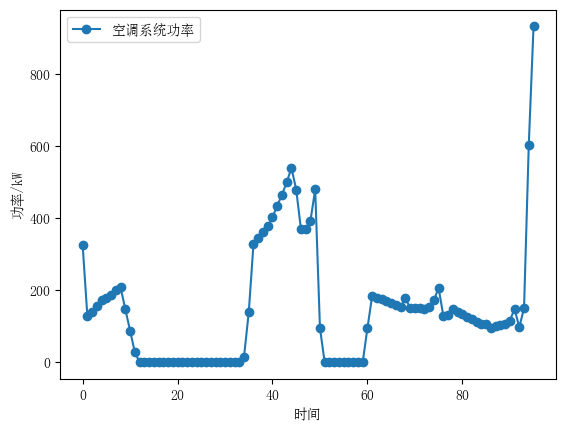

In [34]:
temperature=np.zeros(T)
for i in range(T):
    temperature[i]=P_cooling_t[i].X
plt.plot(temperature,marker='o',label='空调系统功率')
plt.xlabel('时间')
plt.ylabel('功率/kW')
plt.legend()
plt.savefig('bingwang_cooling.pdf',dpi=800)

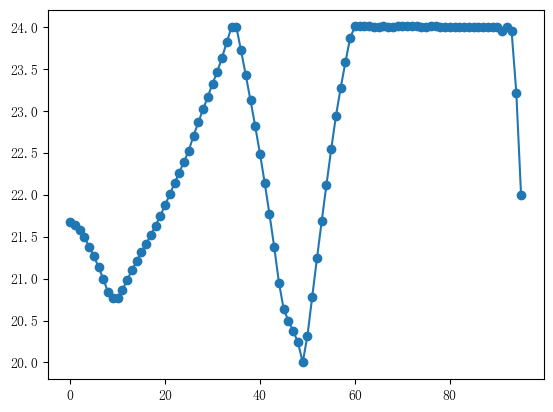

In [57]:
temperature=np.zeros(T)
for i in range(T):
    temperature[i]=T_cooling[i].X
plt.plot(temperature,marker='o')
gen_P_val,gen_Q_val,bus_square_voltages_val,branch_P_val,branch_Q_val,branch_square_currents_val=[],[],[],[],[],[]
gen_P_val=np.array([v.X for v in gen_P.values()])
gen_Q_val=np.array([v.X for v in gen_Q.values()])

for i in range(32):
    tmp_bus_square_voltage_val=np.array([v.X for v in bus_square_voltages[i].values()])
    tmp_branch_p_val=np.array([v.X for v in branch_P[i].values()])
    tmp_branch_q_val=np.array([v.X for v in branch_Q[i].values()])
    tmp_branch_square_current_val=np.array([v.X for v in branch_square_currents[i].values()])
    bus_square_voltages_val.append(tmp_bus_square_voltage_val)
    branch_P_val.append(tmp_branch_p_val)
    branch_Q_val.append(tmp_branch_q_val)
    branch_square_currents_val.append(tmp_branch_square_current_val)
    
WT_val=np.array([v.X for v in P_WT_t.values()])
PV_val=np.array([v.X for v in P_PV_t.values()])
A_BW_val=np.array([v.X for v in A_BW_t.values()])
A_IW_val=np.array([v.X for v in A_IW_t.values()])
A_R_val=np.array([v.X for v in A_R_t.values()])
L_BW_val=np.array([v.X for v in L_BW_t.values()])
L_IW_val=np.array([v.X for v in L_IW_t.values()])
P_data_val=np.array([v.X for v in P_data_t.values()])
P_cooling_val=np.array([v.X for v in P_cooling_t.values()])
T_cooling_val=np.array([v.X for v in T_cooling.values()])
PV_val[0]=0


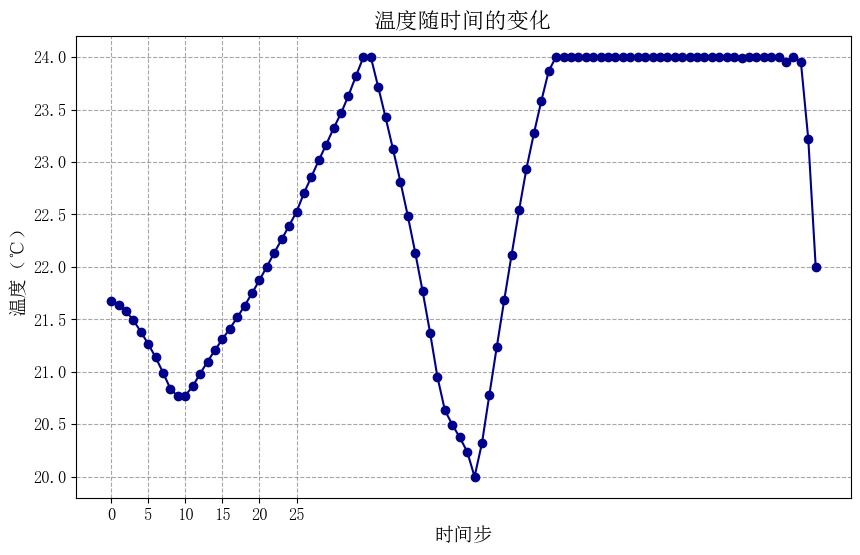

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 假设T_cooling是一个已经定义好的列表或数组
T = len(T_cooling)
temperature = np.zeros(T)

for i in range(T):
    temperature[i] = T_cooling[i].X

# 创建图形
plt.figure(figsize=(10, 6))  # 设置图形大小

# 绘制折线图
plt.plot(temperature, marker='o', linestyle='-', color='darkblue')  # 深蓝色看起来更学术

# 添加标题和轴标签
plt.title('温度随时间的变化', fontsize=16)  # 中文标题
plt.xlabel('时间步', fontsize=14)  # X轴中文标签
plt.ylabel('温度（℃）', fontsize=14)  # Y轴中文标签

# 设置刻度字体大小
plt.xticks([0, 5, 10, 15, 20, 25], fontsize=12)  # 设置X轴刻度
plt.yticks(fontsize=12)

# 添加网格线
plt.grid(True, which="both", ls="--", c='gray', alpha=0.7)

# 显示图形
plt.show()

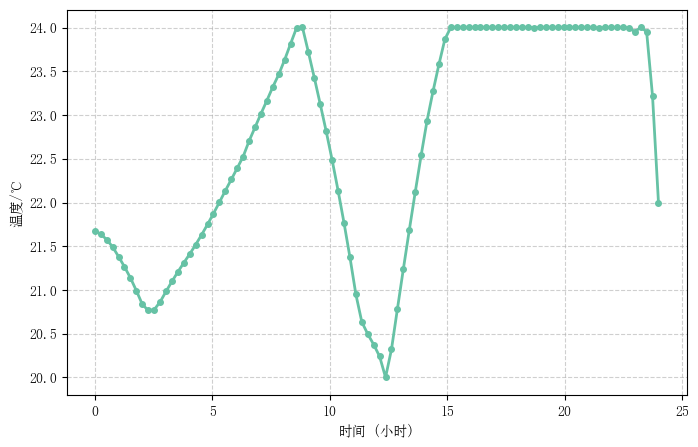

In [54]:
time_points = np.linspace(0, 24, 96)  # 96个时间点，每15分钟一个点

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用于设置无衬线字体，一般用来显示中文
plt.rcParams['font.serif'] = ['Times New Roman']  # 用于设置有衬线字体，一般用来显示英文和数字
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

fig, ax1 = plt.subplots(figsize=(8,5))

# 绘制有功功率
color_active = '#66c2a5'  # 有功功率颜色
ax1.plot(time_points, T_cooling_val, color=color_active, linestyle='-', marker='o', markersize=4, linewidth=2, label='IW处理能力')
ax1.set_xlabel('时间 (小时)', color='black', fontproperties='SimSun')
ax1.set_ylabel('温度/℃', color='black', fontproperties='SimSun')
ax1.tick_params(axis='y', colors='black')
ax1.grid(True, linestyle='--', alpha=0.6)
plt.savefig('温度并网.png',dpi=300)

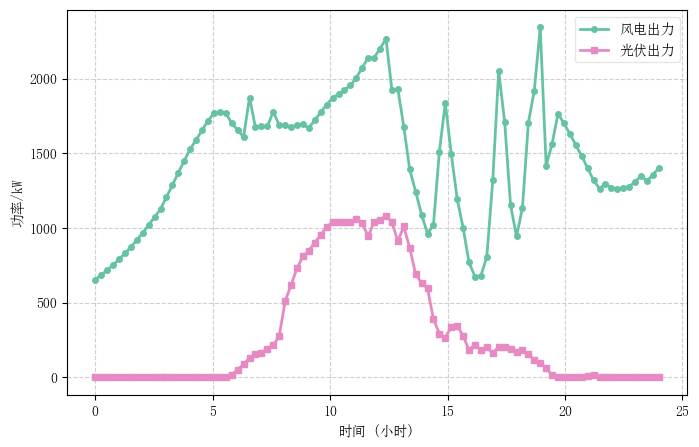

In [63]:
time_points = np.linspace(0, 24, 96)  # 96个时间点，每15分钟一个点

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 用于设置无衬线字体，一般用来显示中文
plt.rcParams['font.serif'] = ['Times New Roman']  # 用于设置有衬线字体，一般用来显示英文和数字
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

fig, ax1 = plt.subplots(figsize=(8,5))

# 绘制有功功率
color_active = '#66c2a5'  # 有功功率颜色
ax1.plot(time_points, WT_val, color=color_active, linestyle='-', marker='o', markersize=4, linewidth=2, label='风电出力')
ax1.set_xlabel('时间 (小时)', color='black', fontproperties='SimSun')
ax1.set_ylabel('功率/kW', color='black', fontproperties='SimSun')
ax1.tick_params(axis='y', colors='black')
ax1.grid(True, linestyle='--', alpha=0.6)

# 创建第二个y轴来绘制无功功率
#ax2 = ax1.twinx()
color_reactive = '#e78ac3'  # 无功功率颜色
ax1.plot(time_points, PV_val, color=color_reactive, linestyle='-', marker='s', markersize=4, linewidth=2, label='光伏出力')
ax1.set_ylabel('功率/kW', color='black', fontproperties='SimSun')
ax1.tick_params(axis='y', colors='black')

# 设置图表标题
#plt.title('IW与BW处理能力', color='black', fontproperties='SimSun')

# 设置图例
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right', framealpha=0.5, prop={'family': 'SimSun'})
plt.savefig('风电光伏并网.png',dpi=300)

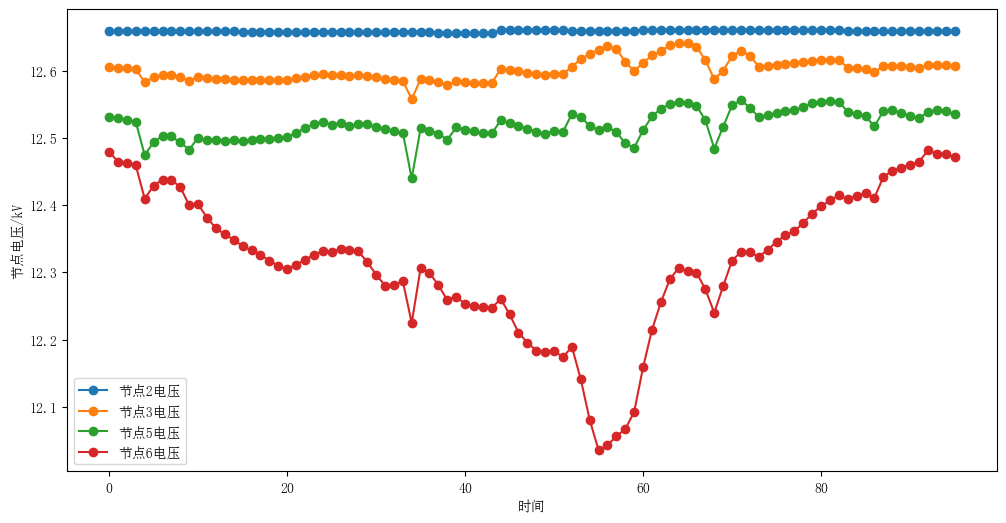

In [17]:
plt.figure(figsize=(12,6))
plt.plot(np.sqrt(bus_square_voltages_val[0]),marker='o',label='节点2电压')
plt.plot(np.sqrt(bus_square_voltages_val[1]),marker='o',label='节点3电压')
plt.plot(np.sqrt(bus_square_voltages_val[3]),marker='o',label='节点5电压')
plt.plot(np.sqrt(bus_square_voltages_val[16]),marker='o',label='节点6电压')
plt.xlabel('时间')
plt.ylabel('节点电压/kV')
plt.legend()
plt.savefig('bingwang_dianya.pdf',dpi=800)

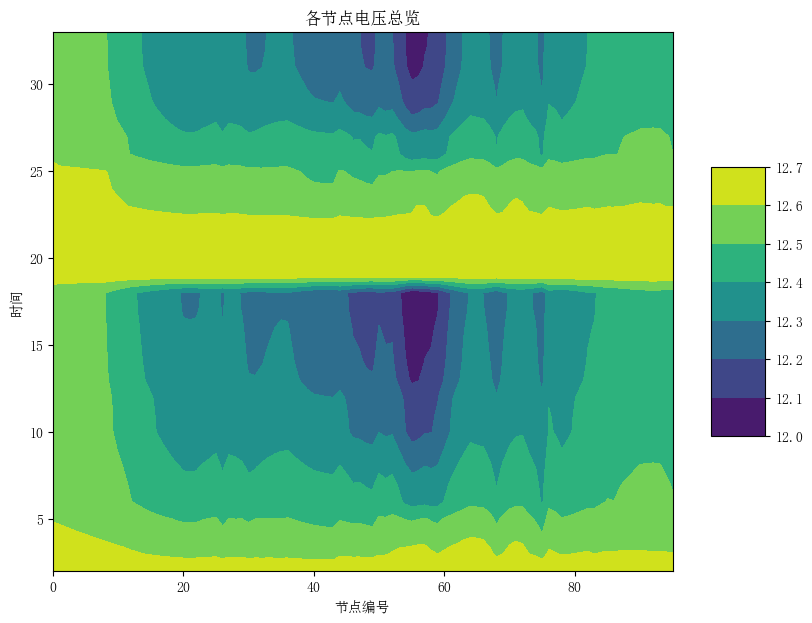

In [69]:
from matplotlib import cm
voltage_data=np.sqrt(np.array(bus_square_voltages_val))

# 创建一个时间轴
time_axis = np.arange(voltage_data.shape[1])  # 假设每个节点有96个时间点
node_axis = np.arange(voltage_data.shape[0])+2  # 32个节点

# 创建一个网格，以便可以为每个节点和时间点分配一个电压值
T, N = np.meshgrid(time_axis, node_axis)

# 创建等高图
plt.figure(figsize=(10, 7))
contours = plt.contourf(T, N, voltage_data, cmap=cm.viridis)
plt.colorbar(contours, shrink=0.5, aspect=5)
plt.xlabel('节点编号')
plt.ylabel('时间')
#plt.title('各节点电压总览')
plt.savefig('总电压并网.png',dpi=800)
plt.show()

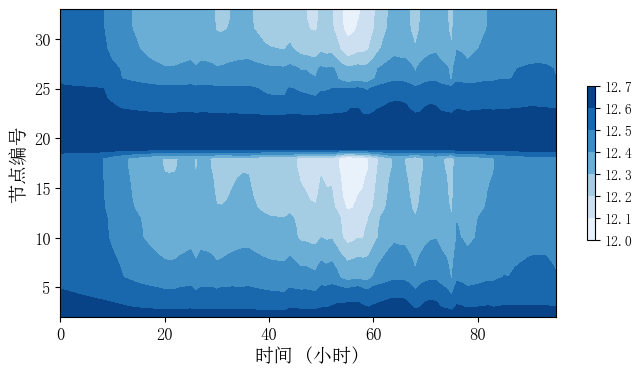

In [78]:
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

# 假设bus_square_voltages_val已经被定义并且包含正确的数据
voltage_data = np.sqrt(np.array(bus_square_voltages_val))

# 创建一个时间轴
time_axis = np.arange(voltage_data.shape[1])  # 假设每个节点有96个时间点
node_axis = np.arange(voltage_data.shape[0]) + 2  # 32个节点

# 创建一个网格，以便可以为每个节点和时间点分配一个电压值
T, N = np.meshgrid(time_axis, node_axis)

# 创建等高图
plt.figure(figsize=(8, 4))  # 增大图表尺寸
contours = plt.contourf(T, N, voltage_data, cmap=cm.Blues)  # 更改为更学术的颜色映射
plt.colorbar(contours, shrink=0.5, aspect=20)  # 调整colorbar的尺寸比例
plt.xlabel('时间 (小时)', fontsize=14)  # 使用更具体的中文标签
plt.ylabel('节点编号', fontsize=14)  # 使用更具体的中文标签
# plt.title('各节点电压分布情况', fontsize=16)  # 可选的中文标题
plt.xticks(fontsize=12)  # 设置X轴刻度字体大小
plt.yticks(fontsize=12)  # 设置Y轴刻度字体大小

# 保存图表
plt.savefig('总电压并网.png', dpi=300, bbox_inches='tight')  # 使用bbox_inches来裁剪多余的空白
plt.show()

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 11131 rows, 13440 columns and 47870 nonzeros
Model fingerprint: 0x2d6515a6
Model has 3072 quadratic constraints
Variable types: 13152 continuous, 288 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+06]
  QMatrix range    [4e+00, 4e+00]
  QLMatrix range   [6e+02, 6e+02]
  Objective range  [5e-03, 3e-01]
  Bounds range     [1e+01, 4e+04]
  RHS range        [6e-02, 2e+08]
Presolve removed 2230 rows and 1478 columns
Presolve time: 0.33s
Presolved: 8901 rows, 11962 columns, 40805 nonzeros
Presolved model has 2976 quadratic constraint(s)
Variable types: 11770 continuous, 192 integer (0 binary)

Root relaxation: objective 4.681691e+04, 4319 iterations, 0.03 seconds (0.04 work units)

    Nodes  

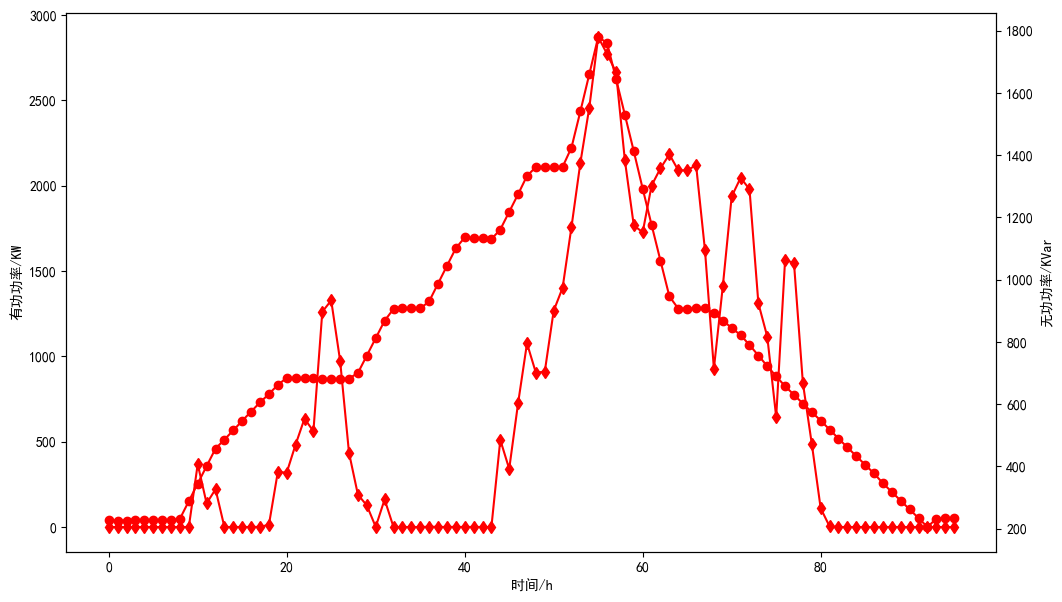

In [37]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import matplotlib.pyplot as plt
from data import *
from IDC_parameters import *
from uncertainty_modelling import WT_96points_quantiles,WT_simulation,PV_simulation,PV_96points_quantiles
#任务2 以最优潮流问题为基础的96点优化调度
#负荷比例：24个小时中，每个时间点每个节点的有功/无功负荷相对基准值（即开头表中值）的比例
#负荷根据实际需要任意修改即可，这里只做实验用
def interpolate_data(data):
    # Ensure input data length is 24
    if len(data) != 24:
        raise ValueError("Input array must have exactly 24 elements.")
    
    # Original x coordinates, from 0 to 23
    x_original = np.arange(24)
    
    # New x coordinates, from 0 to 95, total 96 points
    x_new = np.linspace(0, 24, 96)
    
    # Use linear interpolation function
    f = interp1d(x_original, data, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Interpolate and get new data
    interpolated_data = f(x_new[:-3])  # Handle the first 93 points
    
    # Special handling for the last three points, using the first and last point of the original array for interpolation
    last_point = data[-1]
    first_point = data[0]
    extended_x = np.array([24, 25, 26])
    extended_y = np.array([last_point, first_point, first_point])
    
    # Extended interpolation function
    f_extended = interp1d(extended_x, extended_y, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # Get the data for the last three points
    last_three_points = f_extended(x_new[-3:])
    
    # Combine the two parts of data
    final_data = np.concatenate((interpolated_data, last_three_points))
    
    return final_data

predicted_BWs=4e2*np.array([1.3,2,3.7,4,5.4,5.7,6,6.4,6.8,6,5.8,5.6,5.4,5.7,6,6.4,6.8,6.4,6,5.6,4,3.7,2,1.6])
predicted_IWs=4e2*np.array([0.75,1.2,1.6,2.2,2.75,3.2,3.4,3.5,3.45,3.2,3.0,2.9,
                                        2.9,3.0,3.2,3.4,3.5,3.4,3.2,2.8,2.2,1.6,1.1,0.7])
pq_ratio=np.array([0.1,0.1,0.1,0.2,0.25,0.3,
                   0.3,0.3,0.4,0.4,0.5,0.5,
                   0.6,0.6,0.8,0.6,0.4,0.4,
                   0.36,0.3,0.25,0.2,0.15,0.1])
electricity_price=np.array([29,26,23,23,24,25,31,30,32,33,34,35,37,41,44,52,62,50,40,36,38,34,32,30])
IW_simulation=interpolate_data(predicted_IWs)
BW_simulation=interpolate_data(predicted_BWs)
pq_ratio=interpolate_data(pq_ratio)
electricity_price=interpolate_data(electricity_price)/100
model2=gp.Model('96 point OPF')
#声明各个决策变量，每一个96维的变量表示该节点/电机/线路96个小时中每小时的功率
gen_P=model2.addVars(96,lb=0,ub=6000,vtype=GRB.CONTINUOUS,name=f'generator_p')
gen_Q=model2.addVars(96,lb=0,ub=6000,vtype=GRB.CONTINUOUS,name=f'generator_q')
P_WT_t=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_WT_t')
P_PV_t=model2.addVars(96,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_PV_t')

bus_square_voltages,branch_P,branch_Q,branch_square_currents=[],[],[],[]


for i in range(32):
    tmp_bus_square_voltage=model2.addVars(96,lb=Vmin*Vmin,ub=Vmax*Vmax,vtype=GRB.CONTINUOUS,name=f'bus_square_voltage_{i+1}')
    tmp_branch_p=model2.addVars(96,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_P_{i+1}')
    tmp_branch_q=model2.addVars(96,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name=f'branch_Q_{i+1}')
    tmp_branch_square_current=model2.addVars(96,lb=0,ub=4e4,vtype=GRB.CONTINUOUS,name=f'branch_square_{i+1}')
    bus_square_voltages.append(tmp_bus_square_voltage)
    branch_P.append(tmp_branch_p)
    branch_Q.append(tmp_branch_q)
    branch_square_currents.append(tmp_branch_square_current) 
    
#发电机爬坡功率约束,设发电机爬坡能力为400kW/h
for j in range(1,96):
    model2.addConstr(gen_P[j]-gen_P[j-1]<=1000)
    model2.addConstr(gen_P[j]-gen_P[j-1]>=-1000)
    model2.addConstr(gen_Q[j]-gen_Q[j-1]<=1000)
    model2.addConstr(gen_Q[j]-gen_Q[j-1]>=-1000)
    model2.addConstr(P_WT_t[j]<=max(0,(WT_simulation[j]+WT_96points_quantiles[j])))
    model2.addConstr(P_PV_t[j]<=max(0,(PV_simulation[j]+PV_96points_quantiles[j])))

T=96
TD=16

A_BW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_BW_t')
A_IW_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_IW_t')
A_R_t=model2.addVars(T,lb=0,ub=A_max,vtype=GRB.INTEGER,name='A_R_t')
L_BW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_BW_t')
L_IW_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='L_IW_t')
#P_res_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_res_t')
P_data_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='P_data_t')
P_cooling_t=model2.addVars(T,lb=0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name='p_cooling_t')
T_cooling=model2.addVars(T,lb=10,ub=40,vtype=GRB.CONTINUOUS,name='T_cooling')

#数据中心相关约束
#数据处理相关约束
for i in range(T):
    model2.addConstr(P_data_t[i]==(P_idle+0.75*P_peak)*(A_BW_t[i]+A_IW_t[i])+P_idle*A_R_t[i]+(L_BW_t[i]+L_IW_t[i])*(P_peak-P_idle)/L_rate)
    model2.addConstr(A_IW_t[i]>=L_IW_t[i]/(L_rate-1/C_DT))
    model2.addConstr(L_IW_t[i]==IW_simulation[i])
    model2.addConstr(L_rate*A_BW_t[i]>=L_BW_t[i])
    #对于可延迟负荷，当前处理的功率（累计值）小于当前的负荷值
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i))<=gp.quicksum(BW_simulation[j] for j in range(0,i)))
    #在截止时间之前处理完毕
for i in range(T-TD):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,i+TD))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T-TD,T):
    model2.addConstr(gp.quicksum(L_BW_t[j] for j in range(0,T))>=gp.quicksum(BW_simulation[j] for j in range(0,i)))
for i in range(T):
    model2.addConstr(A_R_t[i]>=redundant_ratio*A_max)
    model2.addConstr(A_IW_t[i]+A_BW_t[i]+A_R_t[i]<=A_max)
#数据中心制冷相关约束
#初始状态T_cooling=T_env=22℃
model2.addConstr(P_cooling_t[0]<=1000)
model2.addConstr(T_cooling[0]==cooling_coef*22+(1-cooling_coef)*T_env[0]+cooling_g*(1-cooling_coef)*P_data_t[0]
                 -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[0])
model2.addConstr(T_cooling[0]>=20)
model2.addConstr(T_cooling[0]<=24)
for i in range(1,96):
    model2.addConstr(P_cooling_t[i]<=1000)
    model2.addConstr(T_cooling[i]==cooling_coef*T_cooling[i-1]+(1-cooling_coef)*T_env[i]+cooling_g*(1-cooling_coef)*P_data_t[i]
                     -cooling_COP*cooling_g*(1-cooling_coef)*P_cooling_t[i])
    model2.addConstr(T_cooling[i]>=20)
    model2.addConstr(T_cooling[i]<=24)      
model2.addConstr(T_cooling[95]==22)

for i in range(96):
    model2.addConstr(branch_P[0][i]==0)
    model2.addConstr(branch_Q[0][i]==0)
#主线
#节点2
#后一个节点电压=前一个节点电压和功率、电流的关系
#后面统一循环变量i表示时间点，循环变量j表示节点
#发电机的懒得改了
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[0][i]==1e6*Vm*Vm-2*1e3*(branch_r[0]*branch_P[0][i]+branch_x[0]*branch_Q[0][i])
                    +(branch_r[0]*branch_r[0]+branch_x[0]*branch_x[0])*branch_square_currents[0][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[0][i]+P_WT_t[i]-branch_square_currents[0][i]*branch_r[0]/1e3==bus_Pd[0]*pq_ratio[i]+branch_P[1][i]+branch_P[17][i])
    model2.addConstr(branch_Q[0][i]-branch_square_currents[0][i]*branch_x[0]/1e3==bus_Qd[0]*pq_ratio[i]+branch_Q[1][i]+branch_Q[17][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[0][i]**2+4*branch_Q[0][i]**2+(branch_square_currents[0][i]-Vm*Vm)**2<=
                    (branch_square_currents[0][i]+Vm*Vm)**2)
#节点3
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[1][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[1]*branch_P[1][i]+branch_x[1]*branch_Q[1][i])
                    +(branch_r[1]*branch_r[1]+branch_x[1]*branch_x[1])*branch_square_currents[1][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[1][i]+gen_P[i]-branch_square_currents[1][i]*branch_r[1]/1e3==bus_Pd[1]*pq_ratio[i]+branch_P[2][i]+branch_P[21][i])
    model2.addConstr(branch_Q[1][i]+gen_Q[i]-branch_square_currents[1][i]*branch_x[1]/1e3==bus_Qd[1]*pq_ratio[i]+branch_Q[2][i]+branch_Q[21][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[1][i]**2+4*branch_Q[1][i]**2+(branch_square_currents[1][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[1][i]+bus_square_voltages[0][i])**2)
#节点4
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[2][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[2]*branch_P[2][i]+branch_x[2]*branch_Q[2][i])
                    +(branch_r[2]*branch_r[2]+branch_x[2]*branch_x[2])*branch_square_currents[2][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[2][i]-branch_square_currents[2][i]*branch_r[2]/1e3==bus_Pd[2]*pq_ratio[i]+branch_P[3][i])
    model2.addConstr(branch_Q[2][i]-branch_square_currents[2][i]*branch_x[2]/1e3==bus_Qd[2]*pq_ratio[i]+branch_Q[3][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[2][i]**2+4*branch_Q[2][i]**2+(branch_square_currents[2][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[2][i]+bus_square_voltages[1][i])**2)
#节点5
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[3][i]==1e6*bus_square_voltages[2][i]-2*1e3*(branch_r[3]*branch_P[3][i]+branch_x[3]*branch_Q[3][i])
                    +(branch_r[3]*branch_r[3]+branch_x[3]*branch_x[3])*branch_square_currents[3][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[3][i]-branch_square_currents[3][i]*branch_r[3]/1e3==bus_Pd[3]*pq_ratio[i]+branch_P[4][i]+P_data_t[i]+P_cooling_t[i])
    model2.addConstr(branch_Q[3][i]-branch_square_currents[3][i]*branch_x[3]/1e3==bus_Qd[3]*pq_ratio[i]+branch_Q[4][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[3][i]**2+4*branch_Q[3][i]**2+(branch_square_currents[3][i]-bus_square_voltages[2][i])**2<=
                    (branch_square_currents[3][i]+bus_square_voltages[2][i])**2)
#节点6
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[4][i]==1e6*bus_square_voltages[3][i]-2*1e3*(branch_r[4]*branch_P[4][i]+branch_x[4]*branch_Q[4][i])
                    +(branch_r[4]*branch_r[4]+branch_x[4]*branch_x[4])*branch_square_currents[4][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[4][i]+P_PV_t[i]-branch_square_currents[4][i]*branch_r[4]/1e3==bus_Pd[4]*pq_ratio[i]+branch_P[5][i]+branch_P[24][i])
    model2.addConstr(branch_Q[4][i]-branch_square_currents[4][i]*branch_x[4]/1e3==bus_Qd[4]*pq_ratio[i]+branch_Q[5][i]+branch_Q[24][i])
    #线上电流关系
    model2.addQConstr(4*branch_P[4][i]**2+4*branch_Q[4][i]**2+(branch_square_currents[4][i]-bus_square_voltages[3][i])**2<=
                    (branch_square_currents[4][i]+bus_square_voltages[3][i])**2)
#节点7到17
#再次强调：循环变量i表示时间点，循环变量j表示节点和线路的编号
for j in range(7,18):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][i]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点18
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[16][i]==1e6*bus_square_voltages[15][i]-2*1e3*(branch_r[16]*branch_P[16][i]+branch_x[16]*branch_Q[16][i])
                    +(branch_r[16]*branch_r[16]+branch_x[16]*branch_x[16])*branch_square_currents[16][i])
    #流入节点功率+节点自身功率=流出节点功率+负荷
    model2.addConstr(branch_P[16][i]-branch_square_currents[16][i]*branch_r[16]/1e3==bus_Pd[16]*pq_ratio[i])
    model2.addConstr(branch_Q[16][i]-branch_square_currents[16][i]*branch_x[16]/1e3==bus_Qd[16]*pq_ratio[i])
    #线上电流关系
    model2.addQConstr(4*branch_P[16][i]**2+4*branch_Q[16][i]**2+(branch_square_currents[16][i]-bus_square_voltages[15][i])**2<=
                    (branch_square_currents[16][i]+bus_square_voltages[15][i])**2)
    
#支路1：节点19到节点22
#节点19
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[17][i]==1e6*bus_square_voltages[0][i]-2*1e3*(branch_r[17]*branch_P[17][i]+branch_x[17]*branch_Q[17][i])
                    +(branch_r[17]*branch_r[17]+branch_x[17]*branch_x[17])*branch_square_currents[17][i])
    model2.addConstr(branch_P[17][i]-branch_square_currents[17][i]*branch_r[17]/1e3==bus_Pd[17]*pq_ratio[i]+branch_P[18][i])
    model2.addConstr(branch_Q[17][i]-branch_square_currents[17][i]*branch_x[17]/1e3==bus_Qd[17]*pq_ratio[i]+branch_Q[18][i])
    model2.addQConstr(4*branch_P[17][i]**2+4*branch_Q[17][i]**2+(branch_square_currents[17][i]-bus_square_voltages[0][i])**2<=
                    (branch_square_currents[17][i]+bus_square_voltages[0][i])**2)
#节点20
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[18][i]==1e6*bus_square_voltages[17][i]-2*1e3*(branch_r[18]*branch_P[18][i]+branch_x[18]*branch_Q[18][i])
                    +(branch_r[18]*branch_r[18]+branch_x[18]*branch_x[18])*branch_square_currents[18][i])
    model2.addConstr(branch_P[18][i]-branch_square_currents[18][i]*branch_r[18]/1e3==bus_Pd[18]*pq_ratio[i]+branch_P[19][i])
    model2.addConstr(branch_Q[18][i]-branch_square_currents[18][i]*branch_x[18]/1e3==bus_Qd[18]*pq_ratio[i]+branch_Q[19][i])
    model2.addQConstr(4*branch_P[18][i]**2+4*branch_Q[18][i]**2+(branch_square_currents[18][i]-bus_square_voltages[17][i])**2<=
                    (branch_square_currents[18][i]+bus_square_voltages[17][i])**2)
#节点21
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[19][i]==1e6*bus_square_voltages[18][i]-2*1e3*(branch_r[19]*branch_P[19][i]+branch_x[19]*branch_Q[19][i])
                    +(branch_r[19]*branch_r[19]+branch_x[19]*branch_x[19])*branch_square_currents[19][i])
    model2.addConstr(branch_P[19][i]-branch_square_currents[19][i]*branch_r[19]/1e3==bus_Pd[19]*pq_ratio[i]+branch_P[20][i])
    model2.addConstr(branch_Q[19][i]-branch_square_currents[19][i]*branch_x[19]/1e3==bus_Qd[19]*pq_ratio[i]+branch_Q[20][i])
    model2.addQConstr(4*branch_P[19][i]**2+4*branch_Q[19][i]**2+(branch_square_currents[19][i]-bus_square_voltages[18][i])**2<=
                    (branch_square_currents[19][i]+bus_square_voltages[18][i])**2)
#节点22
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[20][i]==1e6*bus_square_voltages[19][i]-2*1e3*(branch_r[20]*branch_P[20][i]+branch_x[20]*branch_Q[20][i])
                    +(branch_r[20]*branch_r[20]+branch_x[20]*branch_x[20])*branch_square_currents[20][i])
    model2.addConstr(branch_P[20][i]-branch_square_currents[20][i]*branch_r[20]/1e3==bus_Pd[20]*pq_ratio[i])
    model2.addConstr(branch_Q[20][i]-branch_square_currents[20][i]*branch_x[20]/1e3==bus_Qd[20]*pq_ratio[i])
    model2.addQConstr(4*branch_P[20][i]**2+4*branch_Q[20][i]**2+(branch_square_currents[20][i]-bus_square_voltages[19][i])**2<=
                    (branch_square_currents[20][i]+bus_square_voltages[19][i])**2)

#支路2：节点23到节点25
#节点23
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[21][i]==1e6*bus_square_voltages[1][i]-2*1e3*(branch_r[21]*branch_P[21][i]+branch_x[21]*branch_Q[21][i])
                    +(branch_r[21]*branch_r[21]+branch_x[21]*branch_x[21])*branch_square_currents[21][i])
    model2.addConstr(branch_P[21][i]-branch_square_currents[21][i]*branch_r[21]/1e3==bus_Pd[21]*pq_ratio[i]+branch_P[22][i])
    model2.addConstr(branch_Q[21][i]-branch_square_currents[21][i]*branch_x[21]/1e3==bus_Qd[21]*pq_ratio[i]+branch_Q[22][i])
    model2.addQConstr(4*branch_P[21][i]**2+4*branch_Q[21][i]**2+(branch_square_currents[21][i]-bus_square_voltages[1][i])**2<=
                    (branch_square_currents[21][i]+bus_square_voltages[1][i])**2)
#节点24
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[22][i]==1e6*bus_square_voltages[21][i]-2*1e3*(branch_r[22]*branch_P[22][i]+branch_x[22]*branch_Q[22][i])
                    +(branch_r[22]*branch_r[22]+branch_x[22]*branch_x[22])*branch_square_currents[22][i])
    model2.addConstr(branch_P[22][i]-branch_square_currents[22][i]*branch_r[22]/1e3==bus_Pd[22]*pq_ratio[i]+branch_P[23][i])
    model2.addConstr(branch_Q[22][i]-branch_square_currents[22][i]*branch_x[22]/1e3==bus_Qd[22]*pq_ratio[i]+branch_Q[23][i])
    model2.addQConstr(4*branch_P[22][i]**2+4*branch_Q[22][i]**2+(branch_square_currents[22][i]-bus_square_voltages[21][i])**2<=
                    (branch_square_currents[22][i]+bus_square_voltages[21][i])**2)
#节点25
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[23][i]==1e6*bus_square_voltages[22][i]-2*1e3*(branch_r[23]*branch_P[23][i]+branch_x[23]*branch_Q[23][i])
                    +(branch_r[23]*branch_r[23]+branch_x[23]*branch_x[23])*branch_square_currents[23][i])
    model2.addConstr(branch_P[23][i]-branch_square_currents[23][i]*branch_r[23]/1e3==bus_Pd[23]*pq_ratio[i])
    model2.addConstr(branch_Q[23][i]-branch_square_currents[23][i]*branch_x[23]/1e3==bus_Qd[23]*pq_ratio[i])
    model2.addQConstr(4*branch_P[23][i]**2+4*branch_Q[23][i]**2+(branch_square_currents[23][i]-bus_square_voltages[22][i])**2<=
                    (branch_square_currents[23][i]+bus_square_voltages[22][i])**2)

#支路3：节点26到节点33
#节点26
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[24][i]==1e6*bus_square_voltages[4][i]-2*1e3*(branch_r[24]*branch_P[24][i]+branch_x[24]*branch_Q[24][i])
                    +(branch_r[24]*branch_r[24]+branch_x[24]*branch_x[24])*branch_square_currents[24][i])
    model2.addConstr(branch_P[24][i]-branch_square_currents[24][i]*branch_r[24]/1e3==bus_Pd[24]*pq_ratio[i]+branch_P[25][i])
    model2.addConstr(branch_Q[24][i]-branch_square_currents[24][i]*branch_x[24]/1e3==bus_Qd[24]*pq_ratio[i]+branch_Q[25][i])
    model2.addQConstr(4*branch_P[24][i]**2+4*branch_Q[24][i]**2+(branch_square_currents[24][i]-bus_square_voltages[4][i])**2<=
                    (branch_square_currents[24][i]+bus_square_voltages[4][i])**2)
#节点27到节点32
for j in range(27,33):
    for i in range(96):
        model2.addConstr(1e6*bus_square_voltages[j-2][i]==1e6*bus_square_voltages[j-3][i]-2*1e3*(branch_r[j-2]*branch_P[j-2][i]+branch_x[j-2]*branch_Q[j-2][i])
                    +(branch_r[j-2]*branch_r[j-2]+branch_x[j-2]*branch_x[j-2])*branch_square_currents[j-2][i])
        #流入节点功率+节点自身功率=流出节点功率+负荷
        model2.addConstr(branch_P[j-2][i]-branch_square_currents[j-2][i]*branch_r[j-2]/1e3==bus_Pd[j-2]*pq_ratio[i]+branch_P[j-1][i])
        model2.addConstr(branch_Q[j-2][i]-branch_square_currents[j-2][i]*branch_x[j-2]/1e3==bus_Qd[j-2]*pq_ratio[i]+branch_Q[j-1][i])
        #线上电流关系
        model2.addQConstr(4*branch_P[j-2][i]**2+4*branch_Q[j-2][2]**2+(branch_square_currents[j-2][i]-bus_square_voltages[j-3][i])**2<=
                        (branch_square_currents[j-2][i]+bus_square_voltages[j-3][i])**2)
#节点33
for i in range(96):
    model2.addConstr(1e6*bus_square_voltages[31][i]==1e6*bus_square_voltages[30][i]-2*1e3*(branch_r[31]*branch_P[31][i]+branch_x[31]*branch_Q[31][i])
                    +(branch_r[31]*branch_r[31]+branch_x[31]*branch_x[31])*branch_square_currents[31][i])
    model2.addConstr(branch_P[31][i]-branch_square_currents[31][i]*branch_r[31]/1e3==bus_Pd[31]*pq_ratio[i])
    model2.addConstr(branch_Q[31][i]-branch_square_currents[31][i]*branch_x[31]/1e3==bus_Qd[31]*pq_ratio[i])
    model2.addQConstr(4*branch_P[31][i]**2+4*branch_Q[31][i]**2+(branch_square_currents[31][i]-bus_square_voltages[30][i])**2<=
                    (branch_square_currents[31][i]+bus_square_voltages[30][i])**2)
    

#先优化网损，别的目标函数（如经济性相关）可以自己随便调整
#model2.setObjective(1)
model2.setParam('TimeLimit',600)
model2.setObjective(0.35*gp.quicksum(gen_P[i]  for i in range(T))+0.35*(gp.quicksum(gen_Q[i]  for i in range(T)))
                    #+gp.quicksum(electricity_price[i]*branch_P[0][i] for i in range(T))+gp.quicksum(electricity_price[i]*branch_Q[0][i] for i in range(T))
                    #+0.4*gp.quicksum(P_cooling_t[i] for i in range(T))
                    -C_BW*gp.quicksum(L_BW_t[i] for i in range(T))-C_IW*(gp.quicksum(L_IW_t[i] for i in range(T))),GRB.MINIMIZE)
#model2.setObjective(gp.quicksum(gp.quicksum(branch_square_currents[j][i]*branch_r[j] for j in range(32)) for i in range(96)))

model2.optimize()
print(f"Model status: {model2.Status}")
if model2.Status == 4:
    model2.write('model2.lp')
    print("Model is infeasible, computing IIS...")
    model2.computeIIS()
    print("IIS computed.")

    # 查看 IIS 是否为空
    if model2.IISMinimal:
        print("IIS is non-empty.")
        for constr in model2.getConstrs():
            if constr.IISConstr:
                print(f"Constraint {constr.ConstrName} is in the IIS.")
    else:
        print("IIS is empty.")

gen_active_power,wind_power,photovaltaic_power,gen_reactive_power=[],[],[],[]
for i in range(96):
    gen_active_power.append(gen_P[i].X)
    gen_reactive_power.append(gen_Q[i].X)
    wind_power.append(P_WT_t[i].X)
    photovaltaic_power.append(P_PV_t[i].X)
utility_grid_active_power_exchange,utility_grid_reactive_power_exchange=[],[]
for i in range(96):
    utility_grid_active_power_exchange.append(branch_P[0][i].X)
    utility_grid_reactive_power_exchange.append(branch_Q[0][i].X)

plt.rcParams['font.sans-serif'] = ['SimHei'] 
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

#绘制三个发电机的出力曲线
fig1, ax1 = plt.subplots(figsize=(12,7))
# 绘制左侧Y轴的有功功率数据
ax1.set_xlabel('时间/h')
ax1.set_ylabel('有功功率/KW')
ax2=ax1.twinx()
ax2.set_ylabel('无功功率/KVar') 

ax1.plot(gen_active_power,marker='d',color='r',label='发电机有功功率')
ax2.plot(gen_reactive_power,marker='o',color='r',label='发电机无功功率')
plt.savefig('liwang_fadianji.pdf',dpi=800)
plt.show()
#plt.show()
#plt.show()




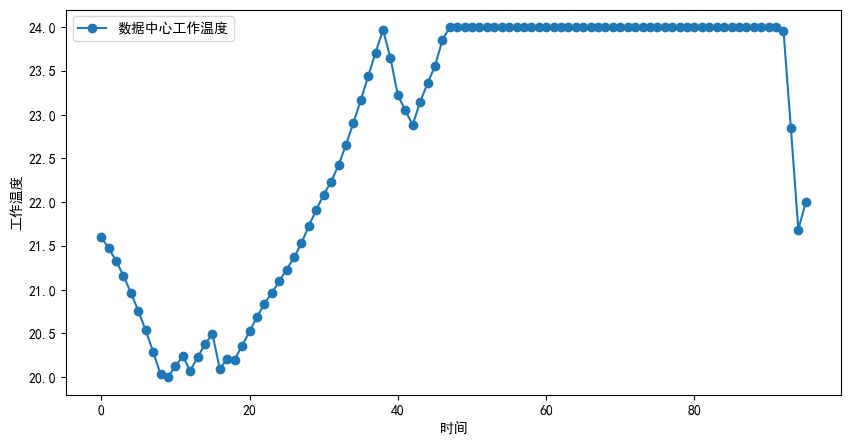

In [52]:
temperature=np.zeros(T)
for i in range(T):
    temperature[i]=T_cooling[i].X
plt.figure(figsize=(10,5))
plt.plot(temperature,marker='o',label='数据中心工作温度')
plt.xlabel('时间')
plt.ylabel('工作温度')
plt.legend()
plt.savefig('liwang_wendu.pdf',dpi=800)
plt.show()
gen_P_val,gen_Q_val,bus_square_voltages_val,branch_P_val,branch_Q_val,branch_square_currents_val=[],[],[],[],[],[]
gen_P_val=np.array([v.X for v in gen_P.values()])
gen_Q_val=np.array([v.X for v in gen_Q.values()])

for i in range(32):
    tmp_bus_square_voltage_val=np.array([v.X for v in bus_square_voltages[i].values()])
    tmp_branch_p_val=np.array([v.X for v in branch_P[i].values()])
    tmp_branch_q_val=np.array([v.X for v in branch_Q[i].values()])
    tmp_branch_square_current_val=np.array([v.X for v in branch_square_currents[i].values()])
    bus_square_voltages_val.append(tmp_bus_square_voltage_val)
    branch_P_val.append(tmp_branch_p_val)
    branch_Q_val.append(tmp_branch_q_val)
    branch_square_currents_val.append(tmp_branch_square_current_val)
    
A_BW_val=np.array([v.X for v in A_BW_t.values()])
A_IW_val=np.array([v.X for v in A_IW_t.values()])
A_R_val=np.array([v.X for v in A_R_t.values()])
L_BW_val=np.array([v.X for v in L_BW_t.values()])
L_IW_val=np.array([v.X for v in L_IW_t.values()])
P_data_val=np.array([v.X for v in P_data_t.values()])
P_cooling_val=np.array([v.X for v in P_cooling_t.values()])
T_cooling_val=np.array([v.X for v in T_cooling.values()])


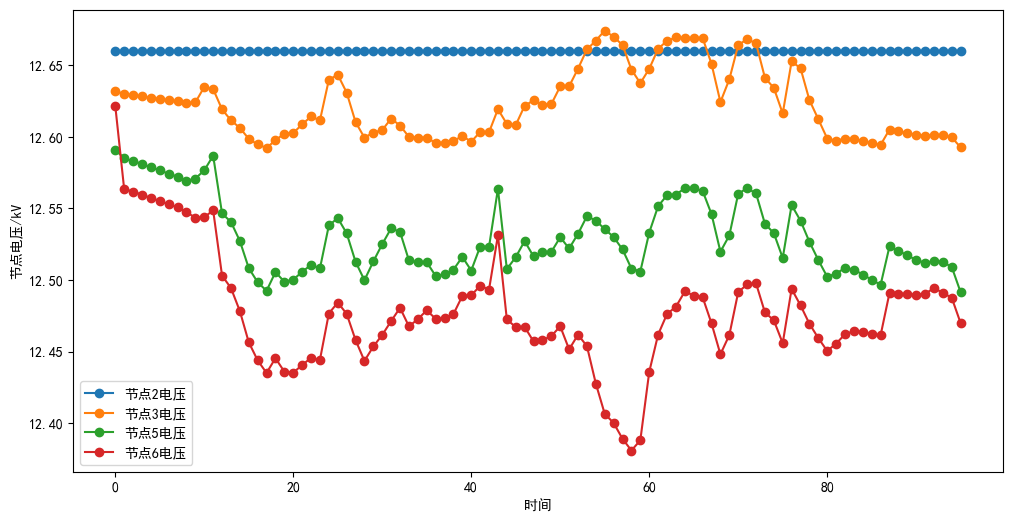

In [39]:
plt.figure(figsize=(12,6))
plt.plot(np.sqrt(bus_square_voltages_val[0]),marker='o',label='节点2电压')
plt.plot(np.sqrt(bus_square_voltages_val[1]),marker='o',label='节点3电压')
plt.plot(np.sqrt(bus_square_voltages_val[3]),marker='o',label='节点5电压')
plt.plot(np.sqrt(bus_square_voltages_val[4]),marker='o',label='节点6电压')
plt.xlabel('时间')
plt.ylabel('节点电压/kV')
plt.legend()
plt.savefig('liwang_dianya.pdf',dpi=800)

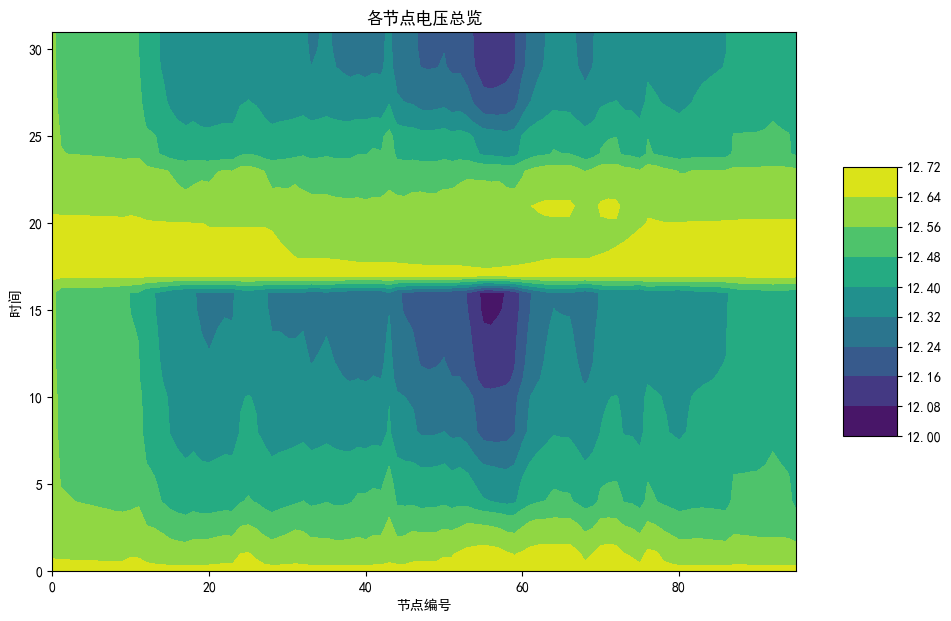

In [40]:
voltage_data=np.sqrt(np.array(bus_square_voltages_val))

# 创建一个时间轴
time_axis = np.arange(voltage_data.shape[1])  # 假设每个节点有96个时间点
node_axis = np.arange(voltage_data.shape[0])  # 32个节点

# 创建一个网格，以便可以为每个节点和时间点分配一个电压值
T, N = np.meshgrid(time_axis, node_axis)

# 创建等高图
plt.figure(figsize=(12, 7))
contours = plt.contourf(T, N, voltage_data, cmap=cm.viridis)
plt.colorbar(contours, shrink=0.5, aspect=5)
plt.xlabel('节点编号')
plt.ylabel('时间')
plt.title('各节点电压总览')
plt.savefig('liwang_all_voltages.pdf',dpi=800)
plt.show()

In [45]:
temperature2=np.zeros(T)
for i in range(T):
    temperature2[i]=T_cooling_val[i]
plt.plot(temperature2,marker='o',label='空调系统功率')
plt.xlabel('时间')
plt.ylabel('功率/kW')
plt.legend()
plt.savefig('liwang_cooling.pdf',dpi=800)

TypeError: only integer scalar arrays can be converted to a scalar index